In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def solution(x, y, t):
    return np.sin(x) * np.sin(y) * np.exp(-2 * t)

In [3]:
spacial_lim = np.pi
N = 10
h = spacial_lim / (N - 1)
tau = 0.01

In [4]:
1 / h**2

8.207015875029361

In [5]:
x = np.linspace(0, spacial_lim, N)
xy = np.meshgrid(x, x)

In [6]:
layer0 = solution(xy[0], xy[1], 0)

<AxesSubplot:>

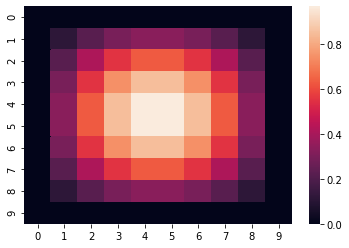

In [7]:
sns.heatmap(layer0)

In [8]:
def thomas_algo(a, b, c, d, n):
    x = np.empty(shape=[n], dtype='float32')
    # Forward sweep
    for i in range(1, n):
        w = a[i] / b[i - 1]
        b[i] = b[i] - w * c[i - 1]
        d[i] = d[i] - w * d[i - 1]
        
    x[-1] = d[-1] / b[-1]
    
    # Backward sweep
    for i in range(n - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
    
    return x

In [9]:
def compute_a():
    a = np.empty(shape=[N], dtype='float32')
    a[0] = np.nan
    a[1:-1] = tau / h**2 / 2
    a[-1] = 0
    return a


def compute_b():
    b = np.empty(shape=[N], dtype='float32')
    b[0] = 1
    b[-1] = 1
    b[1:-1] = -(1 + tau / h**2)
    return b


def compute_c():
    c = np.empty(shape=[N], dtype='float32')
    c[1:] = tau / h**2 / 2
    c[0] = 0
    c[-1] = np.nan
    return c


def compute_d(prev_layer):
    d = np.empty(shape=[N], dtype='float32')
    d[0] = 0
    d[-1] = 0
    diff2 = lambda x_left, x, x_right: (x_left - 2 * x + x_right) / h**2
    for i in range(1, N - 1):
        x_left, x, x_right = prev_layer[i - 1], prev_layer[i], prev_layer[i + 1]
        diff2_val = diff2(x_left, x, x_right)
        d[i] = -x - tau / 2 * diff2_val
    return d

def compute_d(prev_layer):
    d = np.empty(shape=[N], dtype='float32')
    d[0] = 0
    d[-1] = 0
    diff2 = lambda x_left, x, x_right: (x_left - 2 * x + x_right) / h**2
    for i in range(1, N - 1):
        x_left, x, x_right = prev_layer[i - 1], prev_layer[i], prev_layer[i + 1]
        diff2_val = diff2(x_left, x, x_right)
        d[i] = -x - tau / 2 * diff2_val
    return d

In [10]:
def compute_d_v2(left, middle, right):
    d = np.empty(shape=[N], dtype='float32')
    d[0] = 0
    d[-1] = 0
    diff2 = lambda x_left, x, x_right: (x_left - 2 * x + x_right) / h**2
    for i in range(1, N - 1):
        x_left, x, x_right = left[i], middle[i], right[i]
        diff2_val = diff2(x_left, x, x_right)
        d[i] = -x - tau / 2 * diff2_val
    return d

In [11]:
compute_d(layer0[1])

array([ 0.        , -0.1163988 , -0.2187582 , -0.29473212, -0.335157  ,
       -0.335157  , -0.29473212, -0.2187582 , -0.1163988 ,  0.        ],
      dtype=float32)

In [12]:
compute_d_v2(layer0[0], layer0[1], layer0[2])

array([ 0.        , -0.1163988 , -0.2187582 , -0.29473212, -0.335157  ,
       -0.335157  , -0.29473212, -0.2187582 , -0.1163988 ,  0.        ],
      dtype=float32)

In [13]:
def compute_pseudo_layer(layer):
    pseudo_layer_slices = [np.zeros_like(layer[0])]
    for i in range(1, N - 1):
        a = compute_a()
        b = compute_b()
        c = compute_c()
        left, mid, right = layer[i - 1], layer[i], layer[i + 1]
        d = compute_d_v2(left, mid, right)
        x = thomas_algo(a, b, c, d, N)
        pseudo_layer_slices.append(x)
    pseudo_layer_slices.append(np.zeros_like(layer[0])) 
    return np.stack(pseudo_layer_slices, axis=0)

In [14]:
pseudo_layer = compute_pseudo_layer(layer0)

In [15]:
def refine_pseudo_layer(pseudo_layer):
    next_layer_slices = [np.zeros_like(pseudo_layer[0])]
    for i in range(1, N - 1):
        a = compute_a()
        b = compute_b()
        c = compute_c()
        left, mid, right = pseudo_layer[:, i - 1], pseudo_layer[:, i], pseudo_layer[:, i + 1]
        d = compute_d_v2(left, mid, right)
        x = thomas_algo(a, b, c, d, N)
        next_layer_slices.append(x)
    next_layer_slices.append(np.zeros_like(pseudo_layer[0])) 
    return np.stack(next_layer_slices, axis=1)

In [16]:
def compute_next_layer(layer):
    pseudo_layer = compute_pseudo_layer(layer)
    return refine_pseudo_layer(pseudo_layer)

In [17]:
from tqdm import tqdm

def compute_layer_n(layer, n):
    layer = layer
    for i in tqdm(range(n)):
        layer = compute_next_layer(layer)
    return layer

In [24]:
layer100_analytic = solution(xy[0], xy[1], tau * 30)

In [36]:
layer100_computed = compute_layer_n(layer0, 10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


<AxesSubplot:>

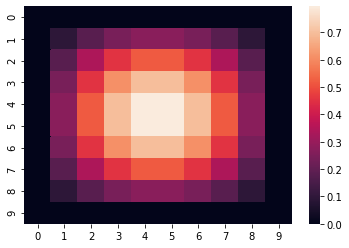

In [37]:
sns.heatmap(layer100_computed)

In [38]:
np.round(layer100_computed, 3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.096, 0.18 , 0.243, 0.276, 0.276, 0.243, 0.18 , 0.096,
        0.   ],
       [0.   , 0.18 , 0.339, 0.457, 0.519, 0.519, 0.457, 0.339, 0.18 ,
        0.   ],
       [0.   , 0.243, 0.457, 0.615, 0.7  , 0.7  , 0.615, 0.457, 0.243,
        0.   ],
       [0.   , 0.276, 0.519, 0.7  , 0.796, 0.796, 0.7  , 0.519, 0.276,
        0.   ],
       [0.   , 0.276, 0.519, 0.7  , 0.796, 0.796, 0.7  , 0.519, 0.276,
        0.   ],
       [0.   , 0.243, 0.457, 0.615, 0.7  , 0.7  , 0.615, 0.457, 0.243,
        0.   ],
       [0.   , 0.18 , 0.339, 0.457, 0.519, 0.519, 0.457, 0.339, 0.18 ,
        0.   ],
       [0.   , 0.096, 0.18 , 0.243, 0.276, 0.276, 0.243, 0.18 , 0.096,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]])

In [28]:
np.round(layer100_analytic, 3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.064, 0.121, 0.163, 0.185, 0.185, 0.163, 0.121, 0.064,
        0.   ],
       [0.   , 0.121, 0.227, 0.306, 0.347, 0.347, 0.306, 0.227, 0.121,
        0.   ],
       [0.   , 0.163, 0.306, 0.412, 0.468, 0.468, 0.412, 0.306, 0.163,
        0.   ],
       [0.   , 0.185, 0.347, 0.468, 0.532, 0.532, 0.468, 0.347, 0.185,
        0.   ],
       [0.   , 0.185, 0.347, 0.468, 0.532, 0.532, 0.468, 0.347, 0.185,
        0.   ],
       [0.   , 0.163, 0.306, 0.412, 0.468, 0.468, 0.412, 0.306, 0.163,
        0.   ],
       [0.   , 0.121, 0.227, 0.306, 0.347, 0.347, 0.306, 0.227, 0.121,
        0.   ],
       [0.   , 0.064, 0.121, 0.163, 0.185, 0.185, 0.163, 0.121, 0.064,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ]])

In [29]:
np.abs(layer100_computed - layer100_analytic).max()

0.0032387185499611615